# FD_2D_DX4_DT2_fast 2-D acoustic Finite-Difference modelling

GNU General Public License v3.0

Author: Florian Wittkamp

Finite-Difference acoustic seismic wave simulation

Discretization of the first-order acoustic wave equation

Temporal second-order accuracy $O(\Delta T^2)$

Spatial fourth-order accuracy  $O(\Delta X^4)$

##  Initialisation

In [194]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Input Parameter

In [195]:
# Discretization
c1=30   # Number of grid points per dominant wavelength
c2=0.2  # CFL-Number
nx=300 # Number of grid points in X
ny=300 # Number of grid points in Y
T=1     # Total propagation time

# Source Signal
f0= 5      # Center frequency Ricker-wavelet
q0= 100       # Maximum amplitude Ricker-Wavelet
xscr = 150  # Source position (in grid points) in X
yscr = 150  # Source position (in grid points) in Y

# Receiver
xrec1=150; yrec1=120;  # Position Reciever 1 (in grid points)
xrec2=150; yrec2=150;  # Position Reciever 2 (in grid points)
xrec3=150; yrec3=180;# Position Reciever 3 (in grid points)

# Velocity and density
modell_v = 3000*np.ones((ny,nx))
rho=2.2*np.ones((ny,nx))

## Preparation

In [196]:
# Init wavefields
vx=np.zeros(shape = (ny,nx))
vy=np.zeros(shape = (ny,nx))
p=np.zeros(shape = (ny,nx))
vx_x=np.zeros(shape = (ny,nx))
vy_y=np.zeros(shape = (ny,nx))
p_x=np.zeros(shape = (ny,nx))
p_y=np.zeros(shape = (ny,nx))

# Calculate first Lame-Paramter
l=rho * modell_v * modell_v

cmin=min(modell_v.flatten())  # Lowest P-wave velocity
cmax=max(modell_v.flatten())  # Highest P-wave velocity
fmax=2*f0                     # Maximum frequency
dx=cmin/(fmax*c1)             # Spatial discretization (in m)
dy=dx                         # Spatial discretization (in m)
dt=dx/(cmax)*c2               # Temporal discretization (in s)
lampda_min=cmin/fmax          # Smallest wavelength

# Output model parameter:
print("Model size: x:",dx*nx,"in m, y:",dy*ny,"in m")
print("Temporal discretization: ",dt," s")
print("Spatial discretization: ",dx," m")
print("Number of gridpoints per minimum wavelength: ",lampda_min/dx)

Model size: x: 3000.0 in m, y: 3000.0 in m
Temporal discretization:  0.0006666666666666668  s
Spatial discretization:  10.0  m
Number of gridpoints per minimum wavelength:  30.0


## Create space and time vector

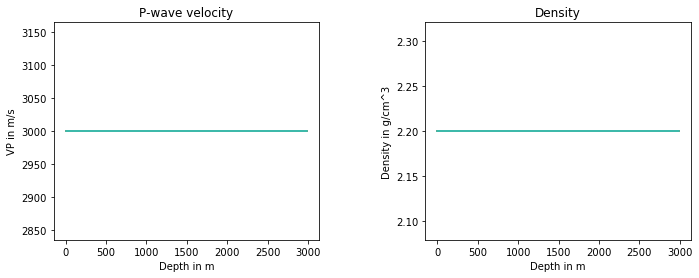

In [197]:
x=np.arange(0,dx*nx,dx) # Space vector in X
y=np.arange(0,dy*ny,dy) # Space vector in Y
t=np.arange(0,T,dt)     # Time vector
nt=np.size(t)           # Number of time steps

# Plotting model
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.subplots_adjust(wspace=0.4,right=1.6)
ax1.plot(x,modell_v)
ax1.set_ylabel('VP in m/s')
ax1.set_xlabel('Depth in m')
ax1.set_title('P-wave velocity')

ax2.plot(x,rho)
ax2.set_ylabel('Density in g/cm^3')
ax2.set_xlabel('Depth in m')
ax2.set_title('Density');


## Source signal - Ricker-wavelet

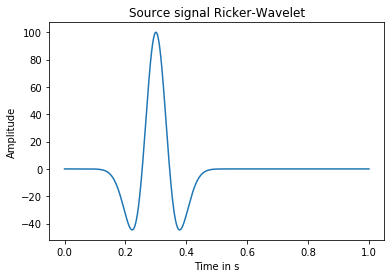

In [198]:
tau=np.pi*f0*(t-1.5/f0)
q=q0*(1.0-2.0*tau**2.0)*np.exp(-tau**2)

# Plotting source signal
plt.figure(3)
plt.plot(t,q)
plt.title('Source signal Ricker-Wavelet')
plt.ylabel('Amplitude')
plt.xlabel('Time in s')
plt.draw()

## Time stepping

In [199]:
# Init Seismograms
Seismogramm=np.zeros((3,nt)); # Three seismograms

# Calculation of some coefficients
i_dx=1.0/(dx)
i_dy=1.0/(dy)
c1=9.0/(8.0*dx)
c2=1.0/(24.0*dx)
c3=9.0/(8.0*dy)
c4=1.0/(24.0*dy)
c5=1.0/np.power(dx,3)
c6=1.0/np.power(dy,3)
c7=1.0/np.power(dx,2)
c8=1.0/np.power(dy,2)
c9=np.power(dt,3)/24.0

# Prepare slicing parameter:
kxM2=slice(5-2,nx-4-2)
kxM1=slice(5-1,nx-4-1)
kx=slice(5,nx-4)
kxP1=slice(5+1,nx-4+1)
kxP2=slice(5+2,nx-4+2)

kyM2=slice(5-2,ny-4-2)
kyM1=slice(5-1,ny-4-1)
ky=slice(5,ny-4)
kyP1=slice(5+1,ny-4+1)
kyP2=slice(5+2,ny-4+2)

## Time stepping
print("Starting time stepping...")
for n in range(2,nt):
        
        # Inject source wavelet
        p[yscr,xscr]=p[yscr,xscr]+q[n]
        
        # Update velocity
        p_x[ky,kx]=c1*(p[ky,kxP1]-p[ky,kx])-c2*(p[ky,kxP2]-p[ky,kxM1])
        p_y[ky,kx]=c3*(p[kyP1,kx]-p[ky,kx])-c4*(p[kyP2,kx]-p[kyM1,kx])
        
        vx=vx-dt/rho*p_x
        vy=vy-dt/rho*p_y
        
        # Update pressure
        vx_x[ky,kx]=c1*(vx[ky,kx]-vx[ky,kxM1])-c2*(vx[ky,kxP1]-vx[ky,kxM2])
        vy_y[ky,kx]=c3*(vy[ky,kx]-vy[kyM1,kx])-c4*(vy[kyP1,kx]-vy[kyM2,kx])
        
        p=p-l*dt*(vx_x+vy_y)
        
        # Save seismograms
        Seismogramm[0,n]=p[yrec1,xrec1]
        Seismogramm[1,n]=p[yrec2,xrec2]
        Seismogramm[2,n]=p[yrec3,xrec3]
        
print("Finished time stepping!")

Starting time stepping...
Finished time stepping!


## Save seismograms

In [200]:
## Save seismograms
np.save("Seismograms/FD_2D_DX4_DT2_fast",Seismogramm)

## Plotting

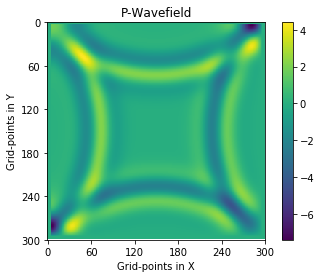

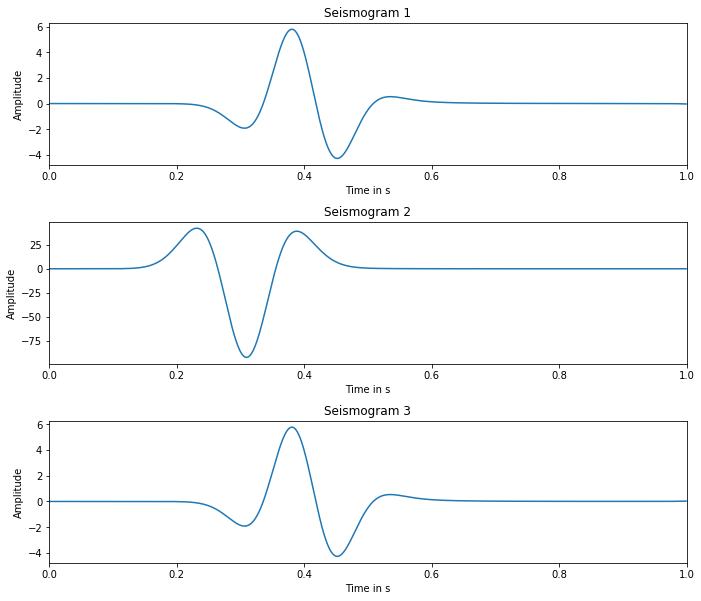

In [201]:
## Image plot
fig, ax = plt.subplots(1,1)
img = ax.imshow(p);
ax.set_title('P-Wavefield')
ax.set_xticks(range(0,nx+1,np.int(nx/5)))
ax.set_yticks(range(0,ny+1,np.int(ny/5)))
ax.set_xlabel('Grid-points in X')
ax.set_ylabel('Grid-points in Y')
fig.colorbar(img)

## Plot seismograms
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
fig.subplots_adjust(hspace=0.4,right=1.6, top = 2 )

ax1.plot(t,Seismogramm[0,:])
ax1.set_title('Seismogram 1')
ax1.set_ylabel('Amplitude')
ax1.set_xlabel('Time in s')
ax1.set_xlim(0, T)

ax2.plot(t,Seismogramm[1,:])
ax2.set_title('Seismogram 2')
ax2.set_ylabel('Amplitude')
ax2.set_xlabel('Time in s')
ax2.set_xlim(0, T)

ax3.plot(t,Seismogramm[2,:])
ax3.set_title('Seismogram 3')
ax3.set_ylabel('Amplitude')
ax3.set_xlabel('Time in s')
ax3.set_xlim(0, T);